In [1]:
!  pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1

In [2]:
! pip install graphviz

In [3]:
! pip install fastbook fastai pandas scikit-learn dtreeviz IPython opendatasets numpy matplotlib seaborn --quiet


In [4]:
! pip install kaggle --quiet

In [5]:
import fastai
fastai.__version__

'2.7.18'

In [5]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [6]:
creds = '{"username":"alishaikhhusain","key":"8e997994b86665a851cae21c41599ee8"}'

In [7]:
# downloading the dataset using the opendatasets library to download the dataset directly from kaggle & to use 
# it inside the jupyter notebook
od.download('https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data')

Skipping, found downloaded files in "./flight-price-prediction" (use force=True to force download)


In [8]:
os.listdir('flight-price-prediction')

['economy.csv', 'Clean_Dataset.csv', 'business.csv']

In [9]:
df = pd.read_csv('flight-price-prediction/Clean_Dataset.csv',low_memory=False)

In [10]:
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [11]:
df.drop(columns=['Unnamed: 0'], inplace=True)

#### embeddings for these categorical variables: 

- `airline`: 6 unique airlines , embedding can help capture the differences between airlines in terms 
of their impacts on the pricing

- `flight`: the flight codes, the number of unique flight codes is large, embeddings are beneficial to model relationships more effectively, this is what embeddings are made for
- `source_city`, `destination_city`: 
6 unique values for both cols, the embeddings are useful for capturing the geographic relationships. Indeed the embeddings are so powerful to use here
- `departure_time`, `arrival_time`:
6 unique bins here for both cols, embeddings might help capture the relationships between time interval and the flight pricing. 



#### one hot encoding we be sufficient: 
- `class`: 2 unique values - so one hot encoding is good 
- `stops`: 3 unique values - so one hot encoding is good 



In [12]:
df.iloc[:,:6]

,airline,flight,source_city,departure_time,stops,arrival_time
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon
4,Vistara,UK-963,Delhi,Morning,zero,Morning
...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening
300149,Vistara,UK-826,Chennai,Afternoon,one,Night
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening


In [13]:
df.iloc[:,6:]


,destination_city,class,duration,days_left,price
0,Mumbai,Economy,2.17,1,5953
1,Mumbai,Economy,2.33,1,5953
2,Mumbai,Economy,2.17,1,5956
3,Mumbai,Economy,2.25,1,5955
4,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...
300148,Hyderabad,Business,10.08,49,69265
300149,Hyderabad,Business,10.42,49,77105
300150,Hyderabad,Business,13.83,49,79099
300151,Hyderabad,Business,10.00,49,81585


In [14]:
# taking the log of the prices will fix how the prices are distributed
# as you can see the prices are now centered and the graph show a good distribution
dep_var = 'price'
df[dep_var] = np.log(df[dep_var])

<Axes: >

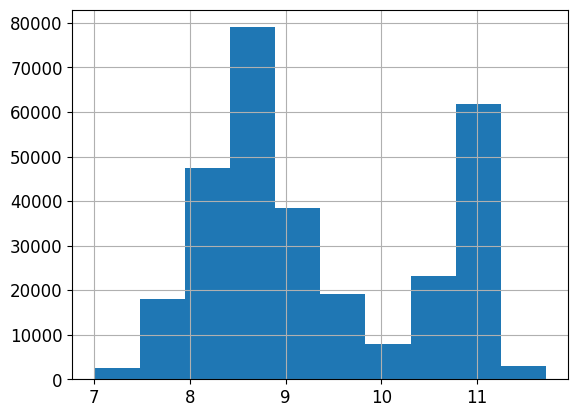

In [15]:
df[dep_var].hist()

In [16]:
from sklearn.model_selection import train_test_split

# lets make a training, validation and test splits
train_validation_sets, test_df = train_test_split(
    df, test_size=0.2, random_state=42)

train_df , val_df = train_test_split(
    train_validation_sets, test_size=0.25, random_state=42)

In [17]:
df = train_validation_sets
splits = RandomSplitter(seed=42)(df)

In [18]:
len(splits[0]), len(splits[1])

(192098, 48024)

why we didn't do much to the categorical variable here? this needs to be answer later on... 

In [19]:
procs = [Categorify, FillMissing]

In [20]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [21]:
cont

['duration', 'days_left']

In [22]:
cat

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']

In [23]:
to = TabularPandas(df, procs,cat,cont,y_names=dep_var,splits=splits)

In [24]:
len(to.train), len(to.valid)

(192098, 48024)

In [25]:
to.show(2)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
239982,Air_India,AI-888,Mumbai,Evening,one,Evening,Hyderabad,Business,24.33,29,10.729700
196814,Air_India,AI-539,Chennai,Evening,one,Late_Night,Bangalore,Economy,7.17,38,8.931684


the categories are converted into numbers using fastAi Categorify class in the procs

In [26]:
to.items.iloc[:,:6]

,airline,flight,source_city,departure_time,stops,arrival_time
239982,2,880,6,3,1,3
196814,2,762,2,3,1,4
48783,6,1495,6,2,1,1
181092,2,762,2,3,3,3
183094,6,1479,2,6,1,3
...,...,...,...,...,...,...
143982,6,1442,5,5,1,6
23313,1,1201,3,2,1,5
8535,6,1544,3,6,3,6
42620,4,679,3,1,1,3


In [27]:
# fastai provides this save method that uses the Python pickle system that saves 
# nearly any Python Object, very cool

save_pickle('./to.pkl',to)

To load this file you can just use this command

```python
to = (path/'to.pkl').load()
```

#### Creating the Decision Tree

In [28]:
to = load_pickle('./to.pkl')

In [29]:
# extract the pandas dataframe inorder to work with the machine learning and deep learning models 
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [32]:
import math
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [33]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.006311, 0.161927)

the training error `0.006311` is significantly lower than the validation error `0.162085`, this suggests that we are **overfitting**

In [34]:
m.get_n_leaves(), len(xs)

(67841, 192098)

we have 67830 leaf nodes so that suggest that we are overfitting

In [35]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, to.valid.xs, to.valid.y)

(0.152348, 0.165594)

this now make more sense, the training and validation errors are the same

In [36]:
m.get_n_leaves()

5477

very nice, lower number of leaf nodes, better generalization

### Create a RandomForest

In [108]:
from sklearn.ensemble import RandomForestRegressor

# we will make a function to traverse and try different parameters for the RandomForest
# n_estimators = 40 --> number of trees, if you have time and enough sleep increase this number
# max_samples = 200,000 rows , but we have 192,000 train datapoints , let's see if anything here breaks 
# max_features = 0.5 --> randomly take half the columns to train a single tree
# min_samples_leaf= 5 --> the final leaf node shall contain at least 5 rows of data (5 airplane tickets)
# n_jobs = -1 --> tell sklearn to use all of our CPU brain power to run this in parallel
# oob_score = True --> explain this later

# things to test here, increase the # of trees, use sklearn default max_feature, use the min_samples_leaf default of sklearn
# then report your findings
def rf(xs, y, n_estimators=50, max_samples=192_098, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [38]:
m = rf(xs,y)

In [39]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.103558, 0.133576)

very good, better than what we have we the `Decision Tree Regressor`

To see the impact of the `n_estimators` we will get every tree form the Forest and make a prediction using it:   

In [40]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featu

In [41]:
# this is how we compare the predictions directly and see the rmse 
r_mse(preds.mean(0),valid_y) 

0.133576

same result as the randomForest

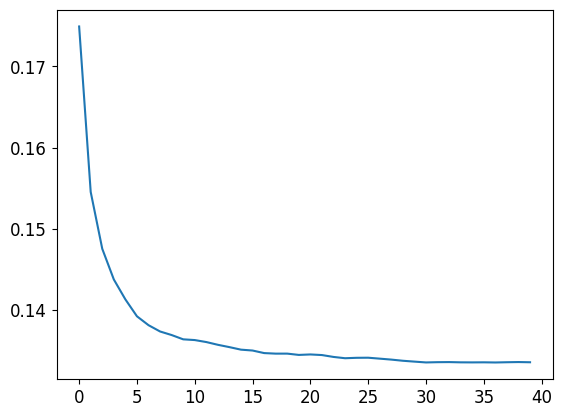

In [42]:
plt.plot([r_mse(preds[:i+1].mean(0),valid_y) for i in range(40)]);

as we use more trees the r_mse goes down even further, this proves the theory that leo breimen came up with in 1996 and then he used desicion trees and showed that his results indeed came to the conclusion that an ensemble of trees will actually give us the correct answer we are looking for

In [43]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.103558, 0.133576)

the validation error is worst than the training error why ? 

In [44]:
r_mse(m.oob_prediction_, y)

0.133893

we have a higher oob_prediction_, we will discover why is that later on .... 

maybe it's because we have 48,024 validation labels to test on

In [45]:
preds.shape

(40, 48024)

How confident the model is regarding each ticket price ? simple use Standard deviation to see weather the trees in the Forest agree on the anwer or not. 


higher stds, means the trees do not agree, lower std means the trees agree

In [46]:
preds_std = preds.std(0)

In [47]:
preds_std[:20]

array([0.00685669, 0.10400772, 0.00859614, 0.08547288, 0.01235191, 0.06621701, 0.17406186, 0.30668613, 0.0807191 , 0.07286215, 0.09701323, 0.03153316, 0.13787133, 0.17853814, 0.02590123, 0.19256356,
       0.03402393, 0.11408279, 0.24156589, 0.00189139])

there is a mix of both, if the trees do not agree on the ticket predicted price you may want to give less attention to this ticket and move on to predicted ticket prices that have lower std. and prepare your self a couple of dinars. 

### Feature Importance in our Model

In [48]:
def rf_feature_importance(m,df):
  return pd.DataFrame(
    {'cols':df.columns, 'imp':m.feature_importances_}
  ).sort_values('imp',ascending=False)
  

In [49]:
fi = rf_feature_importance(m,xs)
fi

,cols,imp
7,class,0.756965
9,days_left,0.064957
1,flight,0.058713
0,airline,0.046385
8,duration,0.037889
4,stops,0.015135
6,destination_city,0.008324
2,source_city,0.006763
5,arrival_time,0.002482
3,departure_time,0.002386


### A plot may help

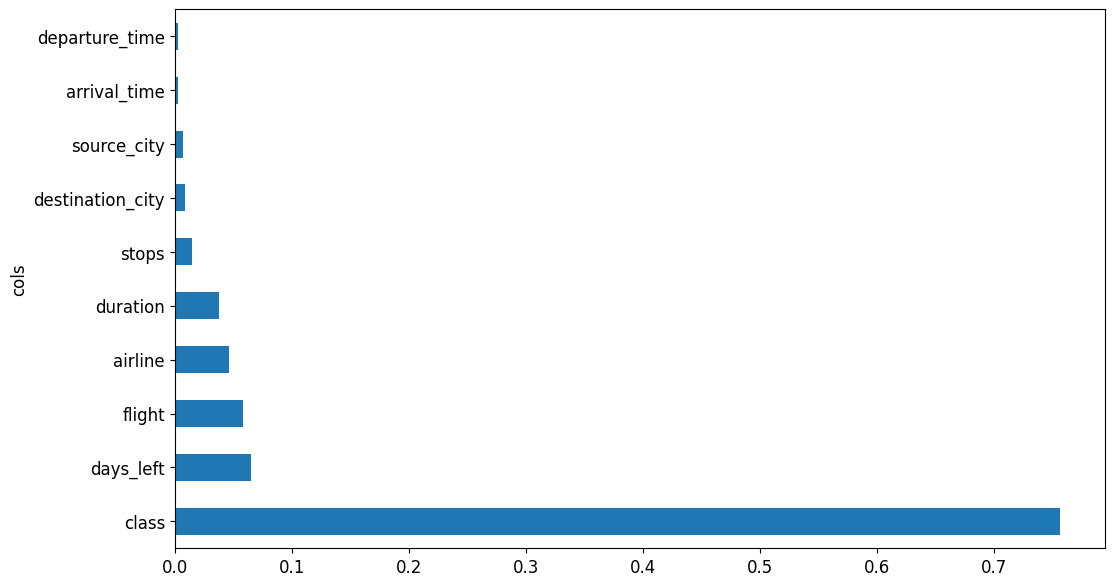

In [50]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7),legend=False)

plot_fi(fi);

#### Removing the low importance Features

In [51]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep),len(fi.cols)

(8, 10)

In [52]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [53]:
m = rf(xs_imp,y)

In [54]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp,valid_y)


(0.107905, 0.137134)

the accuracy for the validation set is about the same (a bit worst), but we have lower columns to study. which is a deal we will take

In [55]:
len(xs.columns) , len(xs_imp.columns) # 8 columns to study

(10, 8)

## Removing Redundant Features

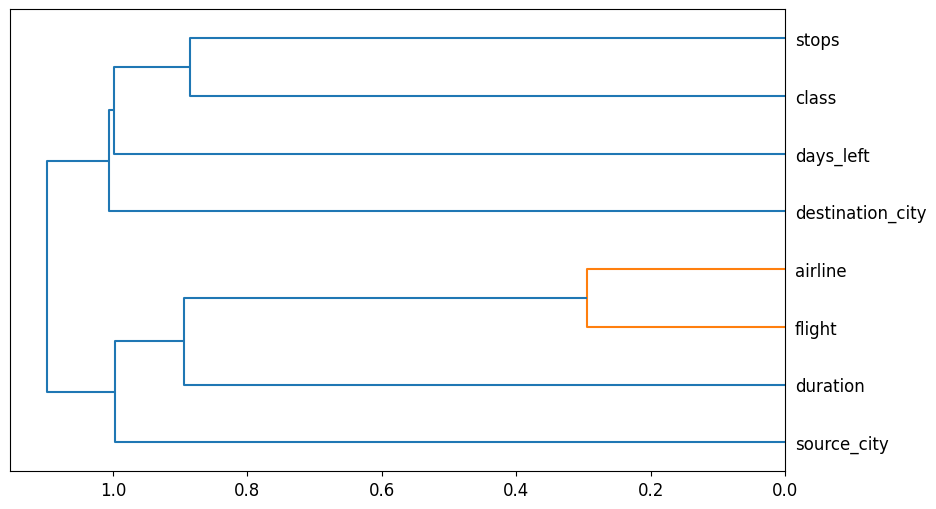

In [56]:
cluster_columns(xs_imp)

In [57]:
# R^2 score --> 1 is excellent
def get_oob(df):
  m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                            max_samples=50000,max_features=0.5,n_jobs=-1,oob_score=True)
  m.fit(df,y)
  return m.oob_score_

get our baseline score: 

In [58]:
get_oob(xs_imp)

0.9738687944897493

In [59]:
{
  c:get_oob(xs_imp.drop(columns=[c]))
  for c in ('airline','flight','days_left','duration','stops','destination_city', 'source_city')
}

{'airline': 0.9724801358671149,
 'flight': 0.9671773310489291,
 'days_left': 0.914406412030294,
 'duration': 0.9711262830405913,
 'stops': 0.9726606102102496,
 'destination_city': 0.9670869108402638,
 'source_city': 0.9686988328613764}

it is clear that all of our remaining features are not redundant so we can keep them, and it is better to keep them

In [60]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [61]:
save_pickle('./xs_final.pkl',xs_final)
save_pickle('./valid_xs_final.pkl',valid_xs_final)

In [62]:
xs = load_pickle('./xs_final.pkl')
val_xs = load_pickle('./valid_xs_final.pkl')

In [63]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, val_xs, valid_y)

(0.10768, 0.136823)

everything is coool, we can continue our laboratory experiments

#### For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?

In [64]:
! pip install treeinterpreter waterfallcharts

In [65]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [66]:
row = val_xs.iloc[:5]

In [67]:
prediction,bias,contributions = treeinterpreter.predict(m,row.values)

In [68]:
prediction[0],bias[0],contributions[0].sum()

(array([8.16294207]), 9.331081314395284, -1.1681392414088756)

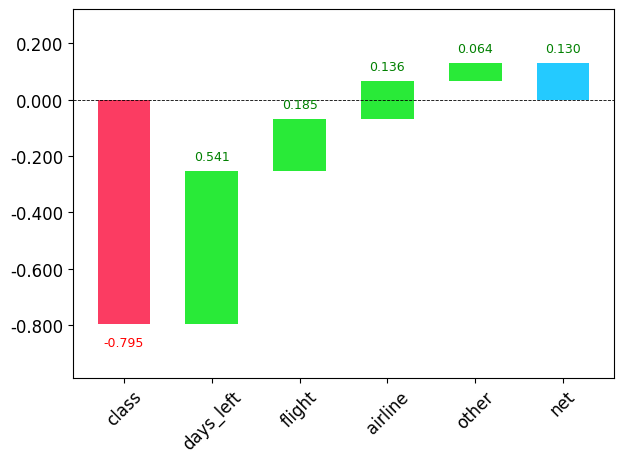

In [69]:
# ';' -> used to hide the unecessary outputs
waterfall(
  val_xs.columns, contributions[3], threshold=0.08,
  rotation_value=45, formatting='{:.3f}'
  );

for a particular row of data, the following attributes help predict the flight ticket price in the following way: 
the class caused the ticket price to go down by - 0.812 then the days_left allowed the price to go higher with a +0.538 then the airline also pushed the price higher, then the flight pushed the price higher, other factors contributed a litte to push the price higher.

this is a good analysis, it represents what really happens in the real world, economy classes are generally cheaper, the days left to a flight generally also makes the price in the real world higher, then the airline pushes the price even higher in the real world and our model seems to think like a human, we need to search about the flight code and how it affects the price. 

this is analysis is good in production settings where if the user asks why the price is high or low, we have this simple data that can provide the answer of what features cause the price to go up or down and by how much, very nice. 

#### using a Neural Network

In [70]:
df_nn = pd.read_csv('flight-price-prediction/Clean_Dataset.csv',low_memory=False)
df_nn[dep_var] = np.log(df_nn[dep_var])

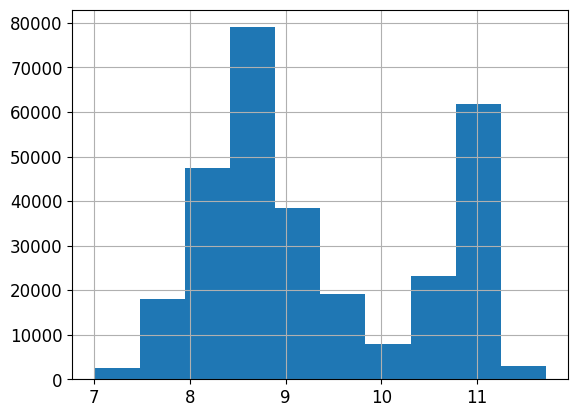

In [71]:
df_nn[dep_var].hist();

In [72]:
df_nn = train_validation_sets.copy()

In [73]:
df_nn_final = df_nn[xs.columns.tolist() +[dep_var]].copy()

In [74]:
df_nn_final['days_left'] = df_nn_final['days_left'].astype(float)

In [75]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 148417 to 121958
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   class             240122 non-null  object 
 1   days_left         240122 non-null  float64
 2   flight            240122 non-null  object 
 3   airline           240122 non-null  object 
 4   duration          240122 non-null  float64
 5   stops             240122 non-null  object 
 6   destination_city  240122 non-null  object 
 7   source_city       240122 non-null  object 
 8   price             240122 non-null  float64
dtypes: float64(3), object(6)
memory usage: 18.3+ MB


In [76]:
# there is a problem with the days_left parameter
# i think this may cause problems, fix it later ... 
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000,dep_var=dep_var)

In [77]:
cat_nn

['class', 'flight', 'airline', 'stops', 'destination_city', 'source_city']

In [78]:
cont_nn

['days_left', 'duration']

In [79]:
df_nn_final[cat_nn].nunique()

class                  2
flight              1560
airline                6
stops                  3
destination_city       6
source_city            6
dtype: int64

In [80]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn,
                      cont_nn, splits=splits, y_names=dep_var)

In [81]:
to_nn.show(2)

,class,flight,airline,stops,destination_city,source_city,days_left,duration,price
239982,Business,AI-888,Air_India,one,Hyderabad,Mumbai,29.0,24.33,10.729700
196814,Economy,AI-539,Air_India,one,Bangalore,Chennai,38.0,7.17,8.931684


In [82]:
to_nn.items['days_left'] # embeddings 

239982    0.220516
196814    0.883789
48783     0.294213
181092   -1.327122
183094   -0.369061
            ...   
143982   -0.811243
23313    -0.442758
8535      1.252274
42620     1.547062
139915    0.441607
Name: days_left, Length: 240122, dtype: float32

In [83]:
dls = to_nn.dataloaders(1024) # do not require much GPU ram

In [84]:
dls.show(2)

,class,flight,airline,stops,destination_city,source_city,days_left,duration,price
239982,Business,AI-888,Air_India,one,Hyderabad,Mumbai,29.0,24.33,10.729700
196814,Economy,AI-539,Air_India,one,Bangalore,Chennai,38.0,7.17,8.931684


In [85]:
to_nn.train.xs

,class,flight,airline,stops,destination_city,source_city,days_left,duration
239982,1,880,2,1,4,6,0.220516,1.684682
196814,2,762,2,1,1,2,0.883789,-0.700372
48783,2,1495,6,1,3,6,0.294213,-0.561383
181092,2,762,2,3,3,2,-1.327122,-1.303585
183094,2,1479,6,1,3,2,-0.369061,1.141234
...,...,...,...,...,...,...,...,...
299035,1,1490,6,1,4,2,-0.000575,-0.422394
152454,2,820,2,1,2,5,1.620759,0.272552
262992,1,715,2,1,3,5,0.441607,1.071739
120037,2,1400,5,3,3,5,-1.548213,-1.349452


In [86]:
y = to_nn.train.y

In [87]:
y.min(),y.max()

(7.007601, 11.720517)

In [88]:
learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(slide=0.009120108559727669, valley=0.0012022644514217973)

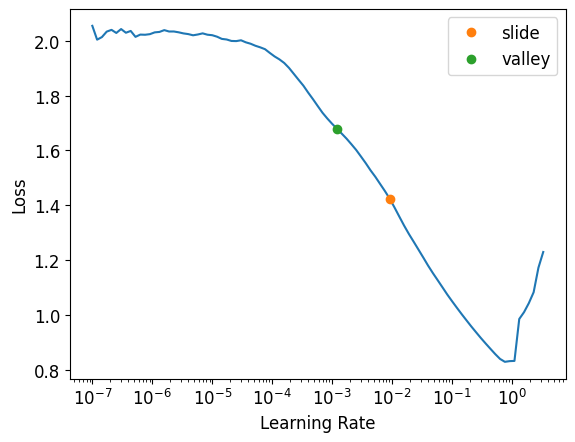

In [89]:
learn.lr_find(suggest_funcs=(slide,valley))

In [90]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.074711,0.051659,00:03
1,0.037559,0.041124,00:03
2,0.030555,0.030863,00:03
3,0.026360,0.027895,00:03
4,0.023235,0.025768,00:03


In [91]:
preds,targets = learn.get_preds()
r_mse(preds, targets)

0.160524

In [92]:
targets.shape

torch.Size([48024, 1])

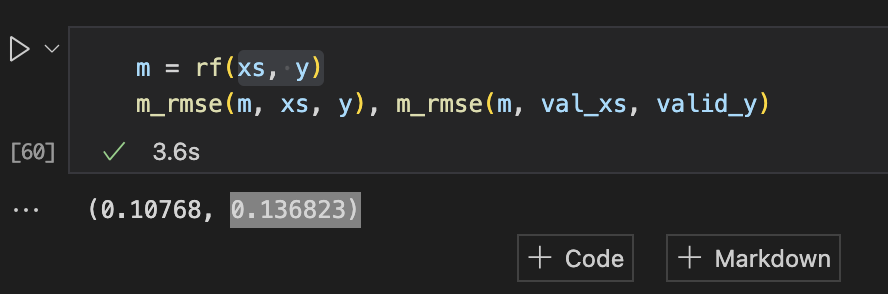

In [93]:
m = rf(xs,y)
m_rmse(m,val_xs,valid_y)


0.137192

In [94]:
rf_preds = m.predict(val_xs)

In [95]:
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [96]:
ens_preds.shape

(48024,)

In [97]:
r_mse(ens_preds,valid_y), r_mse(rf_preds,valid_y), m_rmse(m,val_xs,valid_y)

(0.139151, 0.137192, 0.137192)

In [109]:
def ensemble_nn():
  learn = tabular_learner(dls, y_range=(7,12), layers=[100,50],
                        n_out=1, loss_func=F.mse_loss)
  with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(5, 1e-2)
  prediction = learn.get_preds()[0]
  return to_np(prediction.squeeze())

In [110]:
def ensemble_rf():
  m = rf(xs,y)
  rf_preds = m.predict(val_xs)
  return rf_preds

In [115]:
def ensemble():
    ensemble_nn_preds = [ensemble_nn() for _ in range(40)]
    ensemble_rf_preds = [ensemble_rf() for _ in range(40)]
    preds = np.stack(ensemble_nn_preds+ensemble_rf_preds).mean(0)
    print('prediction shape: ',preds.shape)
    return preds

In [116]:
r_mse(ens_preds,valid_y)

0.139151

In [117]:
r_mse(ensemble(),valid_y) # using 6 models

prediction shape:  (48024,)


0.137258

To conclude the best choice for this dataset is to use the random forest regressor.

### using XGBoost 